In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver

In [4]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.agent_toolkits import FileManagementToolkit

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import PyMuPDFLoader

In [8]:
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import create_react_agent

In [9]:
# 메모리 설정
memory = MemorySaver()

# 모델 설정
llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

In [ ]:
web_search = TavilySearch(
    topic="general",        # 뉴스 주제 (general 또는 news)
    max_results=5,          # 최대 검색 결과
    include_answer=False,
    include_raw_content=False,
    include_images=False,
    format_output=False,  # 결과 포맷팅
)

web_search.name = "web_search"
web_search.description = (
    "Use this tool to search on the web for any topic other than news."
)

In [13]:
result = web_search.search("국민의 힘 단일화에 대해서 알려줘")
result

[{'title': '단일화 추진 기구 내일 출범…김 "넓은 폭 참여" 한 "당에 일임" | Kbs 뉴스',
  'url': 'https://news.kbs.co.kr/news/view.do?ncd=8245142',
  'content': "[앵커] 김문수, 한덕수 두 후보 간 단일화 협상에 본격 시동이 걸렸습니다. 국민의 힘은 후보 선출 하루 만에 단일화 추진 기구를 띄우기로 했고, 한 후보 측은 국민의 당에 단일화 문제를 일임하기로 했습니다. 협상 전망 박영민 기자가 보도합니다. [리포트] 국민의힘이 내일 (5일) '대선 후보 단일화",
  'score': 0.53619206,
  'raw_content': None},
 {'title': '한덕수 "단일화는 국민의 명령…결과에 확실히 승복할 것"(종합) | 연합뉴스',
  'url': 'https://www.yna.co.kr/view/AKR20250507127900001',
  'content': '(서울=연합뉴스) 김승욱 홍국기 기자 = 무소속 한덕수 대통령선거 예비후보는 7일 "단일화는 국민의 명령으로서 잘 이뤄질 것"이라고 말했다. 한 후보는 이날 서울외신기자클럽에서 열린 외신기자간담회에서 \'국민의힘 김문수 후보와의 단일화가 실패할 경우 어떻게 할 것인가\'라는 물음에 "단일화에',
  'score': 0.53298485,
  'raw_content': None},
 {'title': '한덕수 "단일화는 국민의 명령…잘 이뤄질 것" | 연합뉴스',
  'url': 'https://www.yna.co.kr/view/AKR20250507110600001',
  'content': '(서울=연합뉴스) 김승욱 홍국기 기자 = 무소속 한덕수 대통령선거 예비후보는 7일 "단일화는 국민의 명령으로서 잘 이뤄질 것"이라고 말했다. 한 후보는 이날 서울외신기자클럽에서 열린 외신기자간담회에서 \'국민의힘 김문수 후보와의 단일화가 실패할 경우 어떻게 할 것인가\'라는 물음에 "단일화에',
  'score': 0.532

In [14]:
# 'tmp'라는 이름의 디렉토리를 작업 디렉토리로 설정합니다.
working_directory = "tmp9"

# FileManagementToolkit 객체를 생성합니다.
file_management_tools = FileManagementToolkit(
    root_dir=str(working_directory),
).get_tools()

### retriever 도구

In [15]:
# 단계 1: 문서 로드(Load Documents)
loader = PyMuPDFLoader('data/SPRI_AI_Brief_2023년12월호_F.pdf')
docs = loader.load()

In [16]:
# 단계 2: 문서 분할(Split Documents)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_documents = text_splitter.split_documents(docs)

In [17]:
# 단계 3: 임베딩(Embedding) 생성
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

In [18]:
# 단계 4: DB 생성(Create DB) 및 저장
# 벡터스토어를 생성합니다.
vectorstore = FAISS.from_documents(documents=split_documents, embedding=embeddings)

In [19]:
# 단계 5: 검색기(Retriever) 생성
# 문서에 포함되어 있는 정보를 검색하고 생성합니다.
pdf_retriever = vectorstore.as_retriever()

In [20]:
retriever_tool = create_retriever_tool(
    pdf_retriever,          # 리트리버
    name='pdf_retriever',   # 도구의 이름
    
    # 도구에 대한 설명을 자세히 기입해야 합니다. 
    # LLM에게 알려주는 내용인데.. 이 툴을 언제 쓸지 언제 활용하면 좋을지를 영어로 작성합니다.
    description="Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.", 
    
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

In [21]:
tools = [web_search, *file_management_tools, retriever_tool]
tools

[TavilySearch(name='web_search', description='Use this tool to search on the web for any topic other than news.', client=<tavily.tavily.TavilyClient object at 0x000001E76F9AFDD0>, max_results=5, include_raw_content=False),
 CopyFileTool(root_dir='tmp9'),
 DeleteFileTool(root_dir='tmp9'),
 FileSearchTool(root_dir='tmp9'),
 MoveFileTool(root_dir='tmp9'),
 ReadFileTool(root_dir='tmp9'),
 WriteFileTool(root_dir='tmp9'),
 ListDirectoryTool(root_dir='tmp9'),
 Tool(name='pdf_retriever', description='Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001E75E75BEC0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001E76F76B9D0>, search_kwargs={}), document_prompt=PromptTe

### agent 생성

In [23]:
agent_executor = create_react_agent(llm, tools, checkpointer=memory)

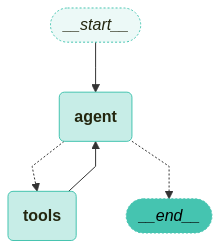

In [24]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(agent_executor)

In [25]:
from langchain_teddynote.messages import stream_graph

In [26]:
# Config 설정
config = {"configurable": {"thread_id": "abc123"}}
inputs = {"messages": [("human", "삼성전자가 만든 생성형 AI 이름에 대해서 알려줘.")]}

# 그래프 스트림
stream_graph(agent_executor, inputs, config, node_names=["agent"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 만든 생성형 AI의 이름은 **삼성 가우스(Samsung Gauss)**입니다. 이 AI는 기업용으로 개발되었으며, 삼성전자의 DX 부문에서 사용됩니다. 삼성 가우스는 다양한 비즈니스 대화에 활용될 수 있는 언어 모델을 포함하고 있습니다.

최근에는 **삼성 가우스2**라는 2세대 모델도 공개되었으며, 이는 언어, 코드, 이미지 등 여러 데이터 유형을 동시에 처리할 수 있는 멀티모달 모델입니다. 삼성전자는 이 모델을 통해 사내 대화형 AI 서비스의 성능을 향상시키고, 코드 생성 서비스의 효율성을 높일 계획입니다.

In [27]:
config = {"configurable": {"thread_id": "abc123"}}
inputs = {
    "messages": [
        (
            "human",
            "한강 작가의 노벨상 수상 관련된 뉴스를 검색하고 보고서 형식에 맞게 작성해줘",
        )
    ]
}
stream_graph(agent_executor, inputs, config, node_names=["agent", "tools"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[{"title": "한강, 한국인 첫 노벨 문학상 수상 - Bbc", "url": "https://www.bbc.com/korean/articles/c93yewwr666o", "content": "소설가 한강, 한국인 첫 노벨 문학상 수상 영예 - BBC News 코리아 한강, 한국인 첫 노벨 문학상 수상 2024년 10월 10일 올해로 53세인 한강 작가는 지난 2016년 소설 '채식주의자'로 세계 3대 문학상 중 하나로 꼽히는 맨부커상 인터내셔널 부문을 수상한 바 있다. 노벨상 수상을 알리는 '특별한' 방법2020년 10월 14일 정보라 작가, '취미는 데모, 시위 현장이 제 소설의 원천'2022년 5월 23일 '흑인여성 첫 노벨문학상' 토니 모리슨 별세2019년 8월 7일 한강은 2022년 프랑스 작가 애니 에르노 이후 첫 여성 노벨문학상 수상자가 됐다. 또한 올해 첫 여성 노벨상 수상자이기도 하다. 2022년 5월 23일 2017년 10월 19일 2019년 8월 7일 2019년 10월 10일 2022년 5월 23일 2020년 10월 14일 2025년 2월 13일 2025년 2월 13일 2025년 2월 13일 2025년 2월 3일 2025년 1월 31일", "score": 0.87681407, "raw_content": null}, {"title": "\"친애하는 한강\" 호명에 기립박수…한국 첫 노벨문학상 수상(종합) | 연합뉴스", "url": "https://www.yna.co.kr/view/AKR20241210144651005", "content": "(스톡홀름=연합뉴스) 김도훈 기자 = 2024 노벨문학상 수상자인 한강 작가가 10일(현지시간) 스웨덴 스톡홀름 콘서트홀에서 열린 시상식에서 칼 구스타프 16

In [28]:
config = {"configurable": {"thread_id": "abc123"}}
inputs = {
    "messages": [
        (
            "human",
            "삼성전자가 만든 생성형 AI에 대해서 문서 검색하고 보고서 형식에 맞게 작성해줘",
        )
    ]
}
stream_graph(agent_executor, inputs, config, node_names=["agent", "tools"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[{"title": "생성형 AI 도입 전략: 대규모 언어 모델 LLM vs. 소규모 언어 모델 SLM | 인사이트리포트 | 삼성SDS", "url": "https://www.samsungsds.com/kr/insights/generative-ai-adoption-strategy.html", "content": "IT ë¦¬ëê° ì ì´ê¶ì ì ì§í  ì ìë í¹ì  ë°ì´í°ë¥¼ ê¸°ë°ì¼ë¡ íê³  ìëì§ ìë¹ê° ì ì ìê·ëª¨ ì¸ì´ ëª¨ë¸ì´ ì£¼ëª©ë°ê³  ììµëë¤. ìµê·¼ ê°í¸ëë ìì±í AI ê¸°ì ì ëí ì  ì¸ê³ ê¸°ìì ì§ì¶ì´ ìì§ê¹ì§ë ê·¸ë¤ì§ í¬ì§ ìë¤ê³  ì¶ì íìµëë¤. ê·¸ë¼ìë ëí ìë¹ì¤ ì ê³µìì²´ë¤ì ìì±í AI ê¸°ì ì ëí ì§ì¶ì ëë¦¬ê³  ììµëë¤. ëí, ìì±í AIì ì§ì ë¬¸í±ì´ ëê³  ëë¶ë¶ì ê¸°ìì´ ì íê° ì°¨ì´ë¥¼ êµ¬ë¶í  ì§ì ìì´ ìë¹ì¤ë¥¼ êµ¬ë§¤í  ì ìê¸° ëë¬¸ì ììê° ê²°ì ì ì£¼ëí  ê°ë¥ì±ì´ ëìµëë¤. ë´ë¶ ì§ì ê¸°ë°ì ë ì ì ìí  ì ì